# <h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Create-pycortex-vertex-objects" data-toc-modified-id="Create-pycortex-vertex-objects-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create pycortex vertex objects</a></span></li><li><span><a href="#Create-figures-etc" data-toc-modified-id="Create-figures-etc-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create figures etc</a></span></li></ul></div>

In [1]:
import cortex as cx
import nilearn.surface as surface
import pandas as pd
import numpy as np
import os, shutil, shlex, subprocess
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib import cm

# needs prfpy for prf spatial plot, and for model predictions at some point
from prfpy.rf import gauss2D_iso_cart
from prfpy.model import Iso2DGaussianModel
import IPython

# %matplotlib notebook

/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
import numpy as np
import scipy as sp
import nilearn as nl
from nilearn.surface import load_surf_data
import os, shutil, urllib.request
import cortex as cx
from matplotlib import rc
# import pybest
import nibabel as nb
from nibabel import cifti2
import h5py
import matplotlib.pyplot as plt

import prfpy
from scipy.io import loadmat
from prfpy.rf import *
from prfpy.timecourse import *
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

from prfpy.model import Iso2DGaussianModel, Norm_Iso2DGaussianModel, DoG_Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter, DoG_Iso2DGaussianFitter, CSS_Iso2DGaussianFitter


import cortex as cx
from prfpy.utils import Subsurface
from prfpy.stimulus import CFStimulus
from prfpy.model import CFGaussianModel
from prfpy.fit import CFFitter
from prfpy.model import Norm_CFGaussianModel
from prfpy.fit import Norm_CFGaussianFitter
from scipy.optimize import LinearConstraint, NonlinearConstraint
import pandas as pd

In [3]:
def angle(x0, y0):
    return np.angle(x0 + y0 * 1j)

def ecc(x0, y0):
    return np.abs(x0 + y0 * 1j)


def basic_plot(dat,vmax,subject='fsaverage',vmin=0,rois=False,colorbar=False,cmap='plasma',ax=None):
    light=cx.Vertex(dat,subject=subject, vmin=vmin, vmax=vmax,cmap=cmap)
    mfig=cx.quickshow(light,with_curvature=True,with_rois=rois,with_colorbar=colorbar,fig=ax)
    
    
def alpha_plot(dat,dat2,vmax,subject='fsaverage',vmin=0,rois=False,colorbar=False,cmap='plasma_alpha',ax=None):
    light=cx.Vertex2D(dat,dat2,subject=subject, vmin=vmin, vmax=vmax,vmin2=0,vmax2=np.nanmax(dat2),cmap=cmap)
    mfig=cx.quickshow(light,with_curvature=True,with_rois=rois,with_colorbar=colorbar,fig=ax)
    
    
from nilearn.surface import load_surf_data
import os

roi_index_dict = {
    # somatosensory:
    'CS1_4': 8, 'CS2_3a': 53, 'CS3_3b': 9, 'CS4_1': 51, 'CS5_2': 52,
    # auditory:
    'A1': 24, 'PBelt': 124, 'MBelt': 173, 'LBelt': 174, '52': 103, 'RI': 104,
    # low-level visual:
    'V1': 1, 'V2': 4, 'V3': 5,
    # mid-level and high-level visual:
    'V3A': 13, 'V3B': 19, 'IPS1': 17, 'LIPv': 48, 'LIPd': 95, 
    'VIP': 49, 'FEF': 10, 'MST': 2, 'MT': 23, 'LO1': 20, 'LO2': 21, 'LO3': 159
    }

atlas_data = np.concatenate([load_surf_data(
        os.path.join('/tank/klundert/content/data/atlas', f'Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'))
         for hemi in ['L', 'R']])
atlas_data_both_hemis = np.mod(atlas_data, 180)


boolmaskV1 = atlas_data_both_hemis == roi_index_dict['V1']


def psc(data):
  
  # crudely checking whether psc hasn't already happened, in which case do nothing
    if np.mean(data) < 0.5:
        return data
    return ((data.T/np.median(data, 1)).T - 1) * 100

import h5py
idxs = h5py.File('/tank/shared/timeless/atlases/cifti_indices.hdf5', "r")
lidxs = np.array(idxs['Left_indices'])
ridxs = np.array(idxs['Right_indices'])

def get_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

    data = np.concatenate([l, r])
    return data

### Parameters

In [4]:
hemis = ['L', 'R']
hemi_names = ['left', 'right']

prf_par_names = ['x', 'y', 'size', 'beta', 'baseline', 'rsq']

subject = 'hcp_999999'
data_dir = os.path.join('/tank/shared/2021/visual/DN-CF/viz_data/data')

tc_gii_filename = 'tfMRI_{run_name}_7T_AP_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries_sg_psc_{hemi}.gii'
# prf_gii_filename = 'retmap_results_barmean_iterative.scalar.{hemi}.gii'
prf_gii_filename = 'V12_retmap_results_polar_bar_iterative.scalar.{hemi}.gii'
design_matrix_filename = '7T_{run_name}_small.hdf5'

run_name = 'RETBAR1'
flatmap_height = 2048


vf_extent = [-8, 8]
nr_vf_pix = 200
prf_space_x, prf_space_y = np.meshgrid(np.linspace(vf_extent[0], vf_extent[1], nr_vf_pix, endpoint=True),
                                       np.linspace(vf_extent[0], vf_extent[1], nr_vf_pix, endpoint=True))

In [5]:
full_figsize = (12, 8)

### Load data
timecourses, prf parameters, and design matrix.

In [6]:
sub = 2
fold = 1

rsq_threshold = 0.4

In [7]:
dnparams = np.load(f'/scratch/2021/nprf_ss/derivatives/prf-fits/sub-0{sub}/dn-prf/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold1.npy')
gaussparams = np.load(f'/scratch/2021/nprf_ss/derivatives/prf-fits/sub-0{sub}/gaussian-prf/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_gaussPRF_params_cv_fold1.npy')
sos = np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/prf_dm.npy')



In [8]:
tc_data = np.vstack([surface.load_surf_data(os.path.join(data_dir, tc_gii_filename.format(
    run_name=run_name, hemi=hemi))) for hemi in hemis])

prf_pars = np.vstack([surface.load_surf_data(os.path.join(
    data_dir, prf_gii_filename.format(hemi=hemi))) for hemi in hemis])
prf_pars_df = pd.DataFrame(prf_pars, columns=prf_par_names)

with h5py.File(os.path.join(data_dir, design_matrix_filename.format(run_name=run_name)), 'r') as f:
    design_matrix = np.array(f.get('stim'))
    
# sos = design_matrix.sum((1,2)) != 0

### Create pycortex vertex objects

In [9]:
angs_n = np.fmod(0.5 + ((np.pi+np.angle(prf_pars_df['x'] +
                          prf_pars_df['y']*1j)) % (2*np.pi))/(2*np.pi), 1.0)
eccen = np.nan_to_num(np.sqrt(prf_pars_df['y']**2 + prf_pars_df['x']**2))
rsq = np.array(prf_pars_df['rsq'])
rsq_mask = rsq > 0.15
prf_size = np.nan_to_num(np.array(prf_pars_df['size']))

angs_n[rsq_mask<0.15] = np.nan
prf_size[rsq_mask<0.15] = np.nan
eccen[rsq_mask<0.15] = np.nan
rsq_mask[rsq_mask<0.15] = np.nan

polar_v = cx.Vertex2D(dim1=angs_n, dim2=rsq_mask, subject=subject,
                      cmap='Retinotopy_RYBCR_alpha', vmin=0, vmax=1.0, vmin2=0.0, vmax2=1)
size_v = cx.Vertex2D(dim1=prf_size, dim2=rsq_mask, subject=subject,
                     cmap='hot_alpha', vmin=0, vmax=7.0, vmin2=0.0, vmax2=1)
eccen_v = cx.Vertex2D(dim1=eccen, dim2=rsq_mask, subject=subject,
                      cmap='Spectral_alpha', vmin=0, vmax=7.0, vmin2=0.0, vmax2=1)
x_v = cx.Vertex2D(dim1=np.nan_to_num(prf_pars_df['x']), dim2=rsq_mask, subject=subject,
                      cmap='seismic_alpha', vmin=-10, vmax=10.0, vmin2=0.15, vmax2=1)
y_v = cx.Vertex2D(dim1=np.nan_to_num(prf_pars_df['y']), dim2=rsq_mask, subject=subject,
                      cmap='seismic_alpha', vmin=-10, vmax=10.0, vmin2=0.15, vmax2=1)


polar_v1D = cx.Vertex(data=angs_n,  subject=subject,
                      cmap='hsv', vmin=0, vmax=1.0, alpha=rsq_mask)
size_v1D = cx.Vertex(data=prf_size, subject=subject,
                     cmap='hot', vmin=0, vmax=5.0, alpha=rsq_mask)
eccen_v1D = cx.Vertex(data=eccen, subject=subject,
                      cmap='BROYG', vmin=0, vmax=7.0, alpha=rsq_mask)

###################################################################################################
###################################################################################################
#######
# create pycortex vars
#######
###################################################################################################
###################################################################################################

mask, extents = cx.quickflat.utils.get_flatmask(subject, height=flatmap_height)
vc = cx.quickflat.utils._make_vertex_cache(subject, height=flatmap_height)

mask_index = np.zeros(mask.shape)
mask_index[mask] = np.arange(mask.sum())

In [10]:
sat = np.ones_like(angs_n)
values = np.ones_like(angs_n)
polar_hsv = hsv_to_rgb(np.array([angs_n, sat, values]).T)

polar_rgb = cm.hsv(angs_n)[:,:3]
eccen_rgb = cm.cubehelix_r(np.sqrt(eccen/6))[:,:3]
size_rgb = cm.cubehelix(np.sqrt((prf_size-0.25)/5))[:,:3]

eccen_rgb /= eccen_rgb.max(0)
size_rgb /= size_rgb.max(0)

print(eccen.max(), prf_size.max())

curv_rgb = np.repeat(cx.db.get_surfinfo('hcp_999999').data[:,np.newaxis], 3, axis=1)

polar_rgb[rsq_mask<0.15] = curv_rgb[rsq_mask<0.15]
eccen_rgb[rsq_mask<0.15] = curv_rgb[rsq_mask<0.15]
size_rgb[rsq_mask<0.15] = curv_rgb[rsq_mask<0.15]

polar_rgb_v = cx.VertexRGB(polar_rgb[:,0], polar_rgb[:,1], polar_rgb[:,2], subject= 'hcp_999999')
eccen_rgb_v = cx.VertexRGB(eccen_rgb[:,0], eccen_rgb[:,1], eccen_rgb[:,2], subject= 'hcp_999999')
size_rgb_v = cx.VertexRGB(size_rgb[:,0], size_rgb[:,1], size_rgb[:,2], subject= 'hcp_999999')

# cx.webgl.make_static(os.path.join(data_dir, f'webgl_all'), data=ds_all) # , overlays_visible=('sulci'), labels_visible=None)
# cx.webshow(data=dict(zip(['polar_angle', 'eccentricity', 'prf_size'], [polar_rgb_v, eccen_rgb_v, size_rgb_v])))#, overlays_visible=('sulci'), labels_visible=None)

nan nan


/tmp/ipykernel_4140102/378919849.py:7: RuntimeWarning: invalid value encountered in sqrt
  size_rgb = cm.cubehelix(np.sqrt((prf_size-0.25)/5))[:,:3]


In [11]:
ds_all = {}
for name, vertex_object in zip(['polar_angle', 'eccentricity', 'prf_size'], [polar_rgb_v, eccen_rgb_v, size_rgb_v]):
    ds = {name: vertex_object.raw}
    try:
        shutil.rmtree(os.path.join(data_dir, f'webgl*'))
    except OSError:
        pass
    cx.webgl.make_static(os.path.join(data_dir, f'webgl_{name}'), ds)
    ds_all.update(ds)
# cx.webgl.make_static(os.path.join(data_dir, f'webgl'), ds_all)
# cx.webshow(ds_all)


### Create figures etc

In [12]:
subject =2
dnparams = get_cortex(np.load(f'/scratch/2021/nprf_ss/derivatives/prf-fits/sub-0{subject}/dn-prf/sub-0{subject}_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold1.npy'))
gaussparams = get_cortex(np.load(f'/scratch/2021/nprf_ss/derivatives/prf-fits/sub-0{subject}/gaussian-prf/sub-0{subject}_task-prf_space-fsLR_den-170k_desc-preproc_gaussPRF_params_cv_fold1.npy'))
sos = np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/prf_dm.npy')



In [13]:
x, y, sig, pamp, boldb, srfamp, srfsig, neurb, surrb, Rsq = dnparams.T

In [32]:
nanmask = Rsq < 0.25

# rvals_dn = Rsq
# rvals_gauss = gaussparams[:,-1]
rvals_gauss = np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/rsq_gauss.npy')
rvals_dn = np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/rsq_dn.npy')
diff = rvals_dn - rvals_gauss
diff[nanmask] = np.nan
rvals_dn[nanmask] = np.nan
eccdn = ecc(dnparams[:,1], dnparams[:,0]*-1)
eccdn[nanmask] = np.nan
pangle = angle(dnparams[:,1], dnparams[:,0]*-1)
pangle[nanmask] = np.nan
sigmadn = sig
sigmadn[nanmask] = np.nan
b_param = neurb
b_param[nanmask] = np.nan
d_param = surrb
d_param[nanmask] = np.nan

In [15]:
s2_f = get_cortex(np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold1_sub-02_psc.npy'))
new_dms = np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/prf_dm.npy')

prf_stim = PRFStimulus2D(screen_size_cm=69, 
                         screen_distance_cm=220, 
                         design_matrix=new_dms.T, 
                         TR=1.5)

grid_nr = 20
max_ecc_size = prf_stim.screen_size_degrees/2.0
sizes, eccs, polars = max_ecc_size * np.linspace(0.25, 1, grid_nr)**2, \
    max_ecc_size * np.linspace(0.1, 1, grid_nr)**2, \
    np.linspace(0, 2*np.pi, grid_nr)

# to set up parameter bounds in iterfit
inf = np.inf
eps = 1e-1
ss = prf_stim.screen_size_degrees

gg = Iso2DGaussianModel(stimulus=prf_stim,
                        filter_predictions=False,
                        filter_type='dc')


gg_norm = Norm_Iso2DGaussianModel(stimulus=prf_stim,
                                    filter_predictions=False,
                                    filter_type='dc',
                                    )

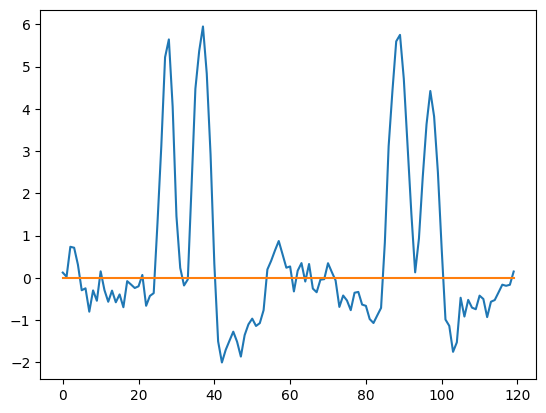

In [16]:
%matplotlib inline
roi_verts = cx.get_roi_verts('hcp_999999', 'V1',mask=True)

maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]

V1_mask = np.concatenate([maskL,maskR])


plt.plot(s2_f[V1_mask][550,:].T, label = 'data')
plt.plot(np.arange(0,120,1), np.arange(0,120,1)*0)

In [17]:
mean_epi = np.load(f'/scratch/2021/nprf_ss/derivatives/Scalars/sub-0{subject}/sub-0{subject}_task-prf_mean-epi.npy')


In [33]:
s2_f_detrend = get_cortex(np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold1_detrend_sub-02_psc.npy'))


In [30]:
np.arange(120)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119])

<IPython.core.display.Javascript object>


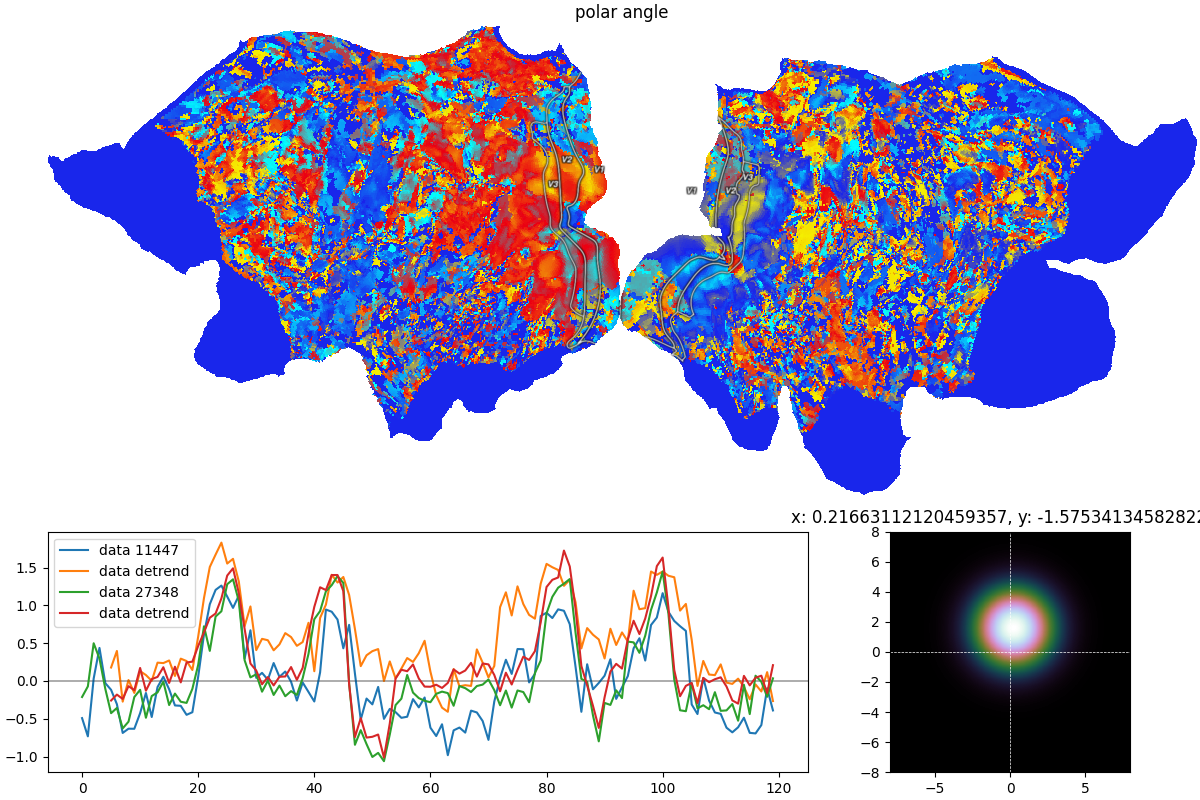

In [37]:
# %matplotlib inline
%matplotlib notebook
# %matplotlib widget
# %matplotlib ipympl

full_fig = plt.figure(constrained_layout=True, figsize=full_figsize)
gs = full_fig.add_gridspec(3, 3)
flatmap_ax = full_fig.add_subplot(gs[:2, :])
timecourse_ax = full_fig.add_subplot(gs[2, :2])
prf_ax = full_fig.add_subplot(gs[2, 2])
flatmap_ax.set_title('flatmap')
timecourse_ax.set_title('timecourse')
prf_ax.set_title('prf')

###################################################################################################
###################################################################################################
#######
# redraw per-vertex data
#######
###################################################################################################
###################################################################################################

def redraw_vertex_plots(vertex, refresh):
    if refresh:
        timecourse_ax.clear()
    timecourse_ax.axhline(0, color='black', lw=0.25)
    timecourse_ax.plot(s2_f[vertex], label = f'data {vertex}')
    timecourse_ax.plot(np.arange(120)[5:], s2_f_detrend[vertex], label = f'data detrend')
#     timecourse_ax.plot(gg_norm.return_prediction(*dnparams[vertex,:-1].T).T, label = 'DN timecourse')
#     timecourse_ax.plot(gg.return_prediction(*gaussparams[vertex,:-1].T).T
# , label = 'gauss timecourse')
    timecourse_ax.legend(loc="upper left")
#     timecourse_ax.plot(sos, alpha=0.125, lw=3, color='gray')
#     timecourse_ax.plot(np.roll(sos,5), alpha=0.25, ls=':', lw=3, color='gray')
    
    


    if prf_pars_df['beta'][vertex] != 0:
        # implement plotting of model predictions using the Iso2DGaussianModel class
        # at some point
        pass

    prf = gauss2D_iso_cart(prf_space_x,
                           prf_space_y,
                           [x[vertex],
                            y[vertex]],
                           sig[vertex])
    prf_ax.clear()
    prf_ax.imshow(prf, extent=vf_extent+vf_extent, cmap='cubehelix')
    prf_ax.axvline(0, color='white', linestyle='dashed', lw=0.5)
    prf_ax.axhline(0, color='white', linestyle='dashed', lw=0.5)
    prf_ax.set_title(f"x: {x[vertex]}, y: {y[vertex]}")

def zoom_to_roi(axis, subject, roi, hem, margin=10.0):
    roi_verts = cx.get_roi_verts(subject, roi)[roi]
    roi_map = cx.Vertex.empty(subject)
    roi_map.data[roi_verts] = 1

    (lflatpts, lpolys), (rflatpts, rpolys) = cx.db.get_surf(subject, "flat",
                                                            nudge=True)
    sel_pts = dict(left=lflatpts, right=rflatpts)[hem]
    roi_pts = sel_pts[np.nonzero(getattr(roi_map, hem))[0], :2]

    xmin, ymin = roi_pts.min(0) - margin
    xmax, ymax = roi_pts.max(0) + margin
    print([xmin, xmax, ymin, ymax])
    axis.axis([xmin, xmax, ymin, ymax])

    return [xmin, xmax, ymin, ymax]

###################################################################################################
###################################################################################################
#######
# actual callback functions
#######
###################################################################################################
###################################################################################################

def onclick(event):
    if event.inaxes == flatmap_ax:
        xmin, xmax = flatmap_ax.get_xbound()
        ax_xrange = xmax-xmin
        ymin, ymax = flatmap_ax.get_ybound()
        ax_yrange = ymax-ymin

        rel_x = int(mask.shape[0] * (event.xdata-xmin)/ax_xrange)
        rel_y = int(mask.shape[1] * (event.ydata-ymin)/ax_yrange)
        clicked_pixel = (rel_x, rel_y)

        clicked_vertex = vc[int(
            mask_index[clicked_pixel[0], clicked_pixel[1]])]

        redraw_vertex_plots(clicked_vertex.indices[0], (event.key == 'shift'))
        plt.draw()

def onkey(event):
    if event.key == '1':  # polar angle
        cx.quickshow(cx.Vertex(rvals_dn, subject='hcp_999999', cmap='inferno', vmin=0), with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)
        flatmap_ax.set_title('Rvals DNCF')
    elif event.key == '2':  # difference rsq
        cx.quickshow(cx.Vertex(rvals_gauss, subject='hcp_999999', cmap='inferno', vmin=0), with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)
        flatmap_ax.set_title('Rsq DN - gauss')
    elif event.key == '3':  # sigma (prf size)
        cx.quickshow(cx.Vertex(sigmadn, subject='hcp_999999', cmap='inferno', vmin=0), with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)
        flatmap_ax.set_title('Sigma')
    elif event.key == '4':  # polar angle
        cx.quickshow(cx.Vertex(pangle, subject='hcp_999999', cmap='Retinotopy_RYBCR', vmin=-np.pi, vmax=np.pi), with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)
        flatmap_ax.set_title('polar angle')
    elif event.key == '5':  # ecc
        cx.quickshow(cx.Vertex(eccdn, subject='hcp_999999', cmap='inferno', vmin=0), with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)
        flatmap_ax.set_title('eccentricity')
    elif event.key == '6':  # b_param
        cx.quickshow(cx.Vertex(b_param, subject='hcp_999999', cmap='inferno', vmin=0), with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)             
        flatmap_ax.set_title('b_param')        
    elif event.key == '7':  # d_param
        cx.quickshow(cx.Vertex(d_param, subject='hcp_999999', cmap='inferno', vmin=0), with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)   
        flatmap_ax.set_title('d_param')    
    elif event.key == '8':  # mean_epi
        cx.quickshow(cx.Vertex(mean_epi, subject='hcp_999999', cmap='YlOrRd'), with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)   
        flatmap_ax.set_title('EPI')    
    plt.draw()
    
###################################################################################################
###################################################################################################
#######
# start
#######
###################################################################################################
###################################################################################################
# start with rvals.
cx.quickshow(cx.Vertex(rvals_dn, subject='hcp_999999', cmap='inferno', vmin=0), with_curvature=True,
             fig=flatmap_ax, with_colorbar=False)



# new_bounds  = zoom_to_roi(axis=flatmap_ax, subject=subject,
#             roi='V2', hem='left', margin=10.0)

full_fig.canvas.mpl_connect('button_press_event', onclick)
full_fig.canvas.mpl_connect('key_press_event', onkey)
plt.show()
plt.ion()
